In [ ]:
%%capture
!pip3 install torch torchvision --extra-index-url https://download.pytorch.org/whl/cu116
!pip3 install rdkit
!pip3 install git+https://github.com/molecularsets/moses.git

In [ ]:
import pandas as pd
import numpy as np
import torch
torch.cuda.set_device(0)
import sys
import os
import tarfile
import gzip
import shutil
from rdkit import Chem
from rdkit.Chem import AllChem
import torch.nn as nn
import torch.optim as optim
from rdkit.Chem import Draw, inchi
from rdkit.Chem.Draw import DrawingOptions
from torch.utils.data import DataLoader, TensorDataset, Dataset
from torchvision import transforms
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
import random
from rdkit import Chem
from rdkit.Chem import AllChem, Descriptors, QED, RDConfig
from rdkit.DataStructs import TanimotoSimilarity
import os
import sys
sys.path.append(os.path.join(RDConfig.RDContribDir, 'SA_Score'))
import sascorer
from moses.utils import disable_rdkit_log
from moses.metrics.utils import get_mol
disable_rdkit_log()

/usr/local/lib/python3.10/dist-packages/moses/metrics/utils.py:24: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  _mcf.append(_pains, sort=True)['smarts'].values]


In [ ]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(device)

cuda


In [ ]:
from google.colab import drive
drive.mount('/content/gdrive')

Mounted at /content/gdrive


In [ ]:
os.chdir('/content/gdrive/My Drive/GENTRL-private')

In [ ]:
expert_df = pd.read_csv("data/canonized/esr1.csv")

In [ ]:
suppl = Chem.SDMolSupplier('data/expert_data/esr1/decoys_final.sdf')
smiles = [Chem.MolToSmiles(x) for x in suppl]

In [ ]:
def canonicalize_smiles_without_stereo(smis):
    """Convert a list of SMILES strings to their canonical forms without stereochemistry."""
    cans = []
    for smi in smis:
        mol = Chem.MolFromSmiles(smi)
        if mol:
            Chem.rdmolops.RemoveStereochemistry(mol)
            cans.append(Chem.MolToSmiles(mol, isomericSmiles=False))
    return cans
smiles = canonicalize_smiles_without_stereo(smiles)

In [ ]:

def get_inchikey(smiles):
    """Get molecule InChIKey from SMILES."""
    mol = Chem.MolFromSmiles(smiles)
    if mol:
        return inchi.MolToInchiKey(mol)
    else:
        return None

def discard_isomers(smiles_list):
    """Discard stereoisomers from a list of SMILES."""
    inchikeys = [get_inchikey(smi) for smi in smiles_list]

    # Extract the first part of the InChIKey (before the first dash) to represent molecular connectivity
    inchikey_parts = [key.split("-")[0] if key else None for key in inchikeys]

    # Create a dictionary with the first part of the InChIKey as the key and the SMILES as the values
    inchikey_to_smiles = {}
    for ikey, smi in zip(inchikey_parts, smiles_list):
        if ikey:
            if ikey in inchikey_to_smiles:
                inchikey_to_smiles[ikey].append(smi)
            else:
                inchikey_to_smiles[ikey] = [smi]

    # From each group of stereoisomers (with the same molecular connectivity), pick one randomly
    retained_smiles = [random.choice(smiles) for smiles in inchikey_to_smiles.values()]

    return retained_smiles

smiles = discard_isomers(smiles)

In [ ]:
decoys_df = pd.DataFrame(smiles, columns=['SMILES'])

In [ ]:
def generate_chemception_image(mol, dim=80):
    # Initialize the image to be of size dim x dim with all zeros (vacuum)
    image = np.zeros((dim, dim, 3))
    mol = Chem.AddHs(mol)

    # Get molecule coordinates after embedding
    if AllChem.EmbedMolecule(mol, Chem.AllChem.ETKDG()) == -1:
        # Embedding failed
        print("Embedding failed for molecule with SMILES:", Chem.MolToSmiles(mol))
        return None

    AllChem.EmbedMolecule(mol, AllChem.ETKDG())
    conf = mol.GetConformer(0)

    # Scale and translate coordinates to fit the image dimensions
    xs = [conf.GetAtomPosition(i).x for i in range(mol.GetNumAtoms())]
    ys = [conf.GetAtomPosition(i).y for i in range(mol.GetNumAtoms())]
    x_min, x_max = min(xs), max(xs)
    y_min, y_max = min(ys), max(ys)
    x_range, y_range = x_max - x_min, y_max - y_min

    scale = 0.95 * dim / max(x_range, y_range)  # Scale down by 95% to provide some buffer
    x_trans, y_trans = (x_max + x_min)/2, (y_max + y_min)/2

    # Assign values to the grid based on atomic properties
    for i in range(mol.GetNumAtoms()):
        x, y = conf.GetAtomPosition(i).x, conf.GetAtomPosition(i).y
        x, y = int((x - x_trans) * scale + dim/2), int((y - y_trans) * scale + dim/2)

        # Make sure coordinates are inside the image
        x = max(0, min(dim-1, x))
        y = max(0, min(dim-1, y))

        # Atomic mass channel (channel 0)
        atom = mol.GetAtomWithIdx(i)
        image[y, x, 0] = atom.GetMass()

    # Assign values based on bonds
    for bond in mol.GetBonds():
        start, end = bond.GetBeginAtomIdx(), bond.GetEndAtomIdx()
        x_start, y_start = conf.GetAtomPosition(start).x, conf.GetAtomPosition(start).y
        x_end, y_end = conf.GetAtomPosition(end).x, conf.GetAtomPosition(end).y

        x_start, y_start = int((x_start - x_trans) * scale + dim/2), int((y_start - y_trans) * scale + dim/2)
        x_end, y_end = int((x_end - x_trans) * scale + dim/2), int((y_end - y_trans) * scale + dim/2)

        # Drawing a simple line between start and end (there are more efficient ways for anti-aliased lines, etc.)
        dx, dy = x_end - x_start, y_end - y_start
        dist = int(np.sqrt(dx*dx + dy*dy))
        for i in range(dist):
            x, y = x_start + i*dx/dist, y_start + i*dy/dist
            if 0 <= x < dim and 0 <= y < dim:
                image[int(y), int(x), 1] = 2  # Bond channel (channel 1)

    return torch.tensor(image).permute(2, 0, 1)  # Channels first format


In [ ]:
class MoleculeDataset(Dataset):
    def __init__(self, tensors, smiles, labels):
        self.tensors = tensors
        self.smiles = smiles
        self.labels = labels

    def __len__(self):
        return len(self.tensors)

    def __getitem__(self, idx):
        return self.tensors[idx], self.smiles[idx], self.labels[idx]

In [ ]:
num_actives = len(expert_df)
balanced_decoys_df = decoys_df.sample(n=num_actives, random_state=42)
expert_df['label'] = 1  # 1 for actives
balanced_decoys_df['label'] = 0  # 0 for decoys
combined_df = pd.concat([expert_df, balanced_decoys_df], axis=0).reset_index(drop=True)

In [ ]:
data_tensors = []
successful_indices = []
successful_smiles = []

for idx, row in combined_df.iterrows():
    smiles = row['SMILES']
    mol = Chem.MolFromSmiles(smiles)
    if mol:
        image_tensor = generate_chemception_image(mol)
        if image_tensor is not None:  # Ensure embedding was successful
            data_tensors.append(image_tensor)
            successful_indices.append(idx)
            successful_smiles.append(smiles)

Embedding failed for molecule with SMILES: [H]C1=C(C([H])([H])[H])c2c3c(c([H])c([H])c2N([H])C1(C([H])([H])[H])C([H])([H])[H])-c1c([H])c(F)c([H])c([H])c1OC3=C1SC([H])([H])C([H])([H])C([H])([H])S1


In [ ]:
data_tensors[0].shape

torch.Size([3, 80, 80])

In [ ]:
data_tensor = torch.stack(data_tensors).float()
successful_smiles = [combined_df.iloc[i]['SMILES'] for i in successful_indices]
labels_array = combined_df['label'].iloc[successful_indices].values
labels_tensor = torch.tensor(labels_array, dtype=torch.float32)

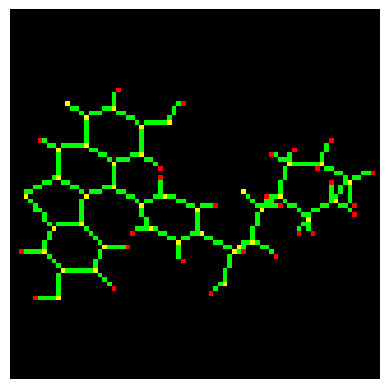

In [ ]:
def visualize_tensor_image(tensor_img, channel=None):
    img = tensor_img.numpy()

    # (height, width, channels)
    if len(img.shape) == 3:
        img = img.transpose((1, 2, 0))

    # visualising a specific channel
    if channel is not None:
        assert len(img.shape) == 3, "The image should have multiple channels to select one"
        img = img[:, :, channel]

    plt.imshow(img)
    plt.axis('off')
    plt.show()

# visualize the first image in the stacked tensor
visualize_tensor_image(data_tensor[0])

# visualize the first channel of the first image
# visualize_tensor_image(data_tensor[0], channel=0)


In [ ]:
assert len(data_tensor) == len(labels_tensor), "Mismatch between data and labels"

In [ ]:
data_train, data_test, labels_train, labels_test, smiles_train, smiles_test = train_test_split(data_tensor, labels_tensor, successful_smiles, test_size=0.2, stratify=labels_tensor)

In [ ]:
train_dataset = MoleculeDataset(data_train, smiles_train, labels_train)
test_dataset = MoleculeDataset(data_test, smiles_test, labels_test)

In [ ]:
train_loader = DataLoader(train_dataset, batch_size=128, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=128, shuffle=True)

In [ ]:
# Model definition
class EnhancedCNN(nn.Module):
    def __init__(self):
        super(EnhancedCNN, self).__init__()

        self.conv_layers = nn.Sequential(
            nn.Conv2d(3, 64, 3, padding=1),
            nn.BatchNorm2d(64),
            nn.ReLU(),
            nn.MaxPool2d(2, 2),

            nn.Conv2d(64, 128, 3, padding=1),
            nn.BatchNorm2d(128),
            nn.ReLU(),
            nn.MaxPool2d(2, 2),

            nn.Conv2d(128, 256, 3, padding=1),
            nn.BatchNorm2d(256),
            nn.ReLU(),
            nn.MaxPool2d(2, 2),

            nn.Conv2d(256, 512, 3, padding=1),
            nn.BatchNorm2d(512),
            nn.ReLU(),
            nn.MaxPool2d(2, 2),

            nn.Conv2d(512, 512, 3, padding=1),
            nn.BatchNorm2d(512),
            nn.ReLU(),
            nn.MaxPool2d(2, 2),
        )

        self.fc_layers = nn.Sequential(
            nn.Linear(2048, 4096),
            nn.ReLU(),
            nn.Dropout(0.5),

            nn.Linear(4096, 4096),
            nn.ReLU(),
            nn.Dropout(0.5),

            nn.Linear(4096, 1)
        )

    def forward(self, x):
        x = self.conv_layers(x)
        x = x.view(x.size(0), -1)
        x = self.fc_layers(x)
        return x


In [ ]:
# Model training function
def train_cnn_model(num_epochs, train_loader, model, criterion, optimizer):
  model.train()  # set the model to training mode
  for epoch in range(num_epochs):
      running_loss = 0.0
      for inputs, smiles_batch, labels in train_loader:
          inputs, labels = inputs.to(device), labels.to(device)
          outputs = model(inputs)
          optimizer.zero_grad()  # zero the parameter gradients
          loss = criterion(outputs.squeeze(), labels)
          loss.backward()
          optimizer.step()
          running_loss += loss.item()
      print(f"Epoch [{epoch + 1}/{num_epochs}], Loss: {running_loss / len(train_loader)}")
  print("Finished Training CNN")

In [ ]:
model = EnhancedCNN().to(device)
criterion = nn.BCEWithLogitsLoss()
optimizer = optim.Adam(model.parameters(), lr=0.00001)

In [ ]:
train_cnn_model(50, train_loader, model, criterion, optimizer)

Epoch [1/50], Loss: 0.012137137725949288
Epoch [2/50], Loss: 0.01160596553236246
Epoch [3/50], Loss: 0.010049744695425033
Epoch [4/50], Loss: 0.009604930598288774
Epoch [5/50], Loss: 0.008350745029747485
Epoch [6/50], Loss: 0.007958111725747586
Epoch [7/50], Loss: 0.006844064965844154
Epoch [8/50], Loss: 0.006215535197407007
Epoch [9/50], Loss: 0.005664347857236862
Epoch [10/50], Loss: 0.0056022445671260355
Epoch [11/50], Loss: 0.005427052266895771
Epoch [12/50], Loss: 0.005043197423219681
Epoch [13/50], Loss: 0.004054326238110662
Epoch [14/50], Loss: 0.003913086373358965
Epoch [15/50], Loss: 0.004010922880843282
Epoch [16/50], Loss: 0.0039018626790493726
Epoch [17/50], Loss: 0.003591308882459998
Epoch [18/50], Loss: 0.0032236124854534863
Epoch [19/50], Loss: 0.003084840811789036
Epoch [20/50], Loss: 0.003177641145884991
Epoch [21/50], Loss: 0.002685940079391003
Epoch [22/50], Loss: 0.0026469002943485974
Epoch [23/50], Loss: 0.00243656262755394
Epoch [24/50], Loss: 0.002469622413627803

In [ ]:
torch.save(model.state_dict(), './models/esr1_active-pred_model.pth')